In [76]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import cvxpy
import ddsketch
import medmnist
import pandas as pd
import torch
import numpy as np
from ddsketch import DDSketch

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

In [77]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [78]:
# path_to_experiments = Path('experiments/')
path_to_experiments = Path('new_experiments/')

In [79]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [80]:
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
# dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'central', 'tct_iid', 'fedavg_iid']

fst, snd = map(itemgetter, range(2))

if dataset == 'fitzpatrick':
    model = 'efficientnet-b1'
    partition = 'skin_type_partition'
    # partition = 'three_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}_pretrained_{partition}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    model = 'small_resnet14'
    partition=None
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
    }
    
experiments = dict(filter(snd, experiments.items()))

In [81]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

for k, v in experiments.items():
    print(f"\n{k.upper().center(20, '=')}")
    print(f" val accuracy {accuracy(v['val_scores'], v['val_targets']):.0%}")
    print(f"test accuracy {accuracy(v['test_scores'], v['test_targets']):.0%}")



======CENTRAL=======
 val accuracy 63%
test accuracy 61%

========TCT=========
 val accuracy 59%
test accuracy 58%

=======FEDAVG=======
 val accuracy 34%
test accuracy 32%

======FEDPROX=======
 val accuracy 31%
test accuracy 31%

======TCT_IID=======
 val accuracy 62%
test accuracy 62%

=====FEDAVG_IID=====
 val accuracy 61%
test accuracy 60%


## Calibrate on one client

In [82]:
get_index = lambda targets, classes: sum([targets == k for k in classes]).bool()

In [83]:
CLIENT = 'client_4'

In [84]:
reload(helpers)
num_trials = 10

client_trials = defaultdict(dict)
fedavg_iid_trials = defaultdict(dict)
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']

    # apply aggregate temperature scaling
    ts.client_temp_scale(
        trial_experiments, clients_class_map, 
        val_df=val_df, test_df=test_df,
        use_three_partition_label=True if partition == 'three_partition_label' else False,
    )
    
    # partition validation data into clients
    if dataset == 'fitzpatrick':
        _partition = 'three_partition_label' if partition == 'three_partition_label' else 'aggregated_fitzpatrick_scale'
        client_index_map = {
            str(part): (val_df[_partition] == part).values for part in sorted(val_df[_partition].unique())
        }
    else:
        client_index_map = {
            k: sum(trial_experiments['fedavg']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()
        }

    # conformal parameters
    # alphas = np.arange(0.05, 1, 0.05)
    alphas = np.arange(0.10, 1, 0.10)
    alphas = list(map(lambda x: np.round(x, 2), alphas))
    allow_empty_sets = False # set to True for upper marginal bound
    method = 'lac' # score function: naive, lac, aps, raps
    # method = 'aps' 
    # method = 'raps' 

    fedavg_val_targets = trial_experiments['fedavg']['val_targets']
    fedavg_test_targets = trial_experiments['fedavg']['test_targets']
    
    val_index = get_index(fedavg_val_targets, clients_class_map[CLIENT])
    
    for client, classes in clients_class_map.items():
        test_index = get_index(fedavg_test_targets, clients_class_map[client])
        metrics = cp.get_coverage_size_over_alphas(
            trial_experiments['fedavg']['temp_val_scores'][val_index], 
            trial_experiments['fedavg']['val_targets'][val_index],
            trial_experiments['fedavg']['temp_test_scores'][test_index], 
            trial_experiments['fedavg']['test_targets'][test_index], 
            method=method, 
            allow_empty_sets=allow_empty_sets, alphas=alphas, 
            decentral=False,
        )
        client_trials[client][i] = metrics
        
    metrics = cp.get_coverage_size_over_alphas(
        trial_experiments['fedavg']['temp_val_scores'][val_index], 
        trial_experiments['fedavg']['val_targets'][val_index],
        trial_experiments['fedavg']['temp_test_scores'],
        trial_experiments['fedavg']['test_targets'],
        method=method, 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=False,
    )
    client_trials['all'][i] = metrics

#     fedavg_iid_val_targets = trial_experiments['fedavg_iid']['val_targets']
#     fedavg_iid_test_targets = trial_experiments['fedavg_iid']['test_targets']
    
#     val_index = get_index(fedavg_iid_val_targets, clients_class_map['client_0'])
    
#     for client, classes in clients_class_map.items():
#         test_index = get_index(fedavg_iid_test_targets, clients_class_map[client])
#         metrics = cp.get_coverage_size_over_alphas(
#             trial_experiments['fedavg_iid']['temp_val_scores'][val_index], 
#             trial_experiments['fedavg_iid']['val_targets'][val_index],
#             trial_experiments['fedavg_iid']['temp_test_scores'][test_index], 
#             trial_experiments['fedavg_iid']['test_targets'][test_index], 
#             method=method, 
#             allow_empty_sets=allow_empty_sets, alphas=alphas, 
#             decentral=False,
#         )
#         fedavg_iid_trials[client][i] = metrics

    print(f'finished trial={i}')

finished trial=0
finished trial=1
finished trial=2
finished trial=3
finished trial=4
finished trial=5
finished trial=6
finished trial=7
finished trial=8
finished trial=9


In [85]:
client_results = {}
for k in client_trials.keys():
    client_results[k] = helpers.combine_trials(client_trials[k])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


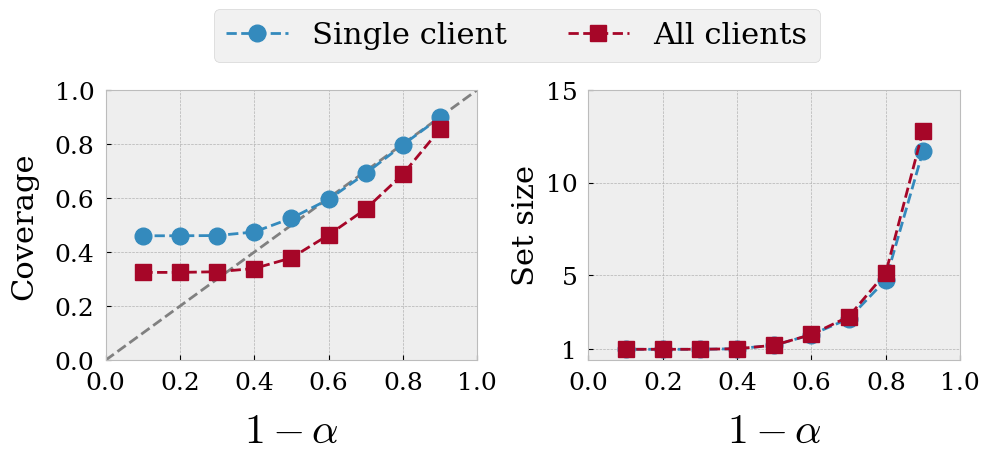

In [86]:
label1 = f'Single client'
label2 = r'All clients'
fontsize=22
markersize=12
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot([0, 1], [0, 1], '--', color='gray')
# for client, results in client_results.items():
ax[0].plot(*zip(*client_results[CLIENT]['mean']['coverage'].items()), '--', marker='o', label=label1, markersize=markersize)
ax[0].plot(*zip(*client_results['all']['mean']['coverage'].items()), '--', marker='s', label=label2, markersize=markersize)
# ax[0].legend(fontsize=fontsize-4, loc='lower right')
# ax[0].set_ylim(0.5, 1)
ax[0].set_xlabel(r'$1 - \alpha$', fontsize=fontsize+8, labelpad=12)
ax[0].set_ylabel('Coverage', fontsize=fontsize, labelpad=12)
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[1].plot(*zip(*client_results[CLIENT]['mean']['size'].items()), '--', marker='o', markersize=markersize)
ax[1].plot(*zip(*client_results['all']['mean']['size'].items()), '--', marker='s', markersize=markersize)
# ax[1].legend(fontsize=fontsize-4, loc='upper left')
ax[1].set_xlabel(r'$1 - \alpha$', fontsize=fontsize+8, labelpad=12)
ax[1].set_ylabel('Set size', fontsize=fontsize, labelpad=4)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].set_xlim(0, 1)
ax[1].set_yticks([1, 5, 10, 15])

ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax[0].set_ylim(0.1, 1)
# # ax[1].set_ylim(-2, 25)
fig.legend(ncol=4, fontsize=fontsize, 
          # title='', title_fontsize=fontsize, 
          bbox_to_anchor=(0.000, 0, 0.84, 1.18), fancybox = True, #shadow = True,
           # mode="expand",
 )

plt.tight_layout()
plt.savefig(fig_dir / f'client-miscover-{dataset}-{partition}.eps', bbox_inches='tight')
plt.show()

In [87]:
reload(helpers)
_partition = 'three_partition_label' if partition == 'three_label_partition' else 'aggregated_fitzpatrick_scale'
partitions = sorted(df[_partition].unique())
local_partition_trials = defaultdict(dict) 
decen_partition_trials = defaultdict(dict) 

alphas = list(map(lambda x: np.round(x, 2), np.arange(0.05, 1, 0.05)))
num_trials = 20
              
for i in range(num_trials):
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']
    
    # apply aggregate temperature scaling
    ts.client_temp_scale(
        trial_experiments, clients_class_map, 
        val_df=val_df, test_df=test_df,
        use_three_partition_label=True if partition == 'three_partition_label' else False,
    )
    
    # partition into clients
    val_index_map = {
        p: (val_df[_partition] == p).values for p in partitions
    }
    test_index_map = {
        p: (test_df[_partition] == p).values for p in partitions
    }
    
    for p in partitions:
        val_index = val_index_map[4.0]
        test_index = test_index_map[p]

        local_results = cp.get_coverage_size_over_alphas(
            trial_experiments['fedavg']['temp_val_scores'][val_index],
            trial_experiments['fedavg']['val_targets'][val_index],
            trial_experiments['fedavg']['temp_test_scores'][test_index],
            trial_experiments['fedavg']['test_targets'][test_index],
            alphas,
            method='lac', 
            allow_empty_sets=False,
            # allow_empty_sets=True,
        )
        local_partition_trials[p][i] = local_results
        
    print(f'finished trial {i}')

NameError: name 'df' is not defined

In [ ]:
style = 'o--'
markersize=8
lw=2
fontsize=22
alphas=np.arange(0.01, 1, 0.05)
figsize=(12, 5)

if partition == 'skin_type_partition':
    colors = plt.cm.copper_r(np.linspace(0, 0.75, 6))
else:
    colors = [mpl.colormaps['viridis'].colors[c] for c in  [255, 16, 155]]

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
# fig.suptitle()

for i, (p, v) in enumerate(local_partition_trials.items()):
    local_results = helpers.combine_trials(v)['mean']

    # ax[0].plot([min(alphas), max(alphas)], [1-max(alphas), 1-min(alphas)], ':', color='gray')
    ax.plot([0, 1], [0, 1], '-', color='gray')

    if partition == 'skin_type_partition':
        label = f'Skin type {int(p)}'
    else:
        label = f'{p.capitalize()}'
    ax.plot(*zip(*local_results['coverage'].items()), style, color=colors[i], label=label, markersize=markersize, lw=lw)
    # ax[1].plot(*zip(*local_results['size'].items()), style, color=colors[i], label=label, markersize=markersize, lw=lw)
    ax.set_xlabel(r'$1-\alpha$', fontsize=fontsize)
    ax.set_ylabel('Coverage', fontsize=fontsize)
    ax.set_xticks([ 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_xlim(0.4, 1)
    ax.set_ylim(0.1, 1)
    ax.xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
    ax.yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
    ax.legend(fancybox=True, fontsize=fontsize-6, ncol=2, loc='lower center')#title='clients', title_fontsize=fontsize)
    
plt.savefig(fig_dir / f'client-miscover-{dataset}-{partition}.eps', bbox_inches='tight')
plt.show()

In [15]:
for k, v in experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    experiments[k]['temp_val_scores'] = val_scores
    experiments[k]['temp_test_scores'] = test_scores

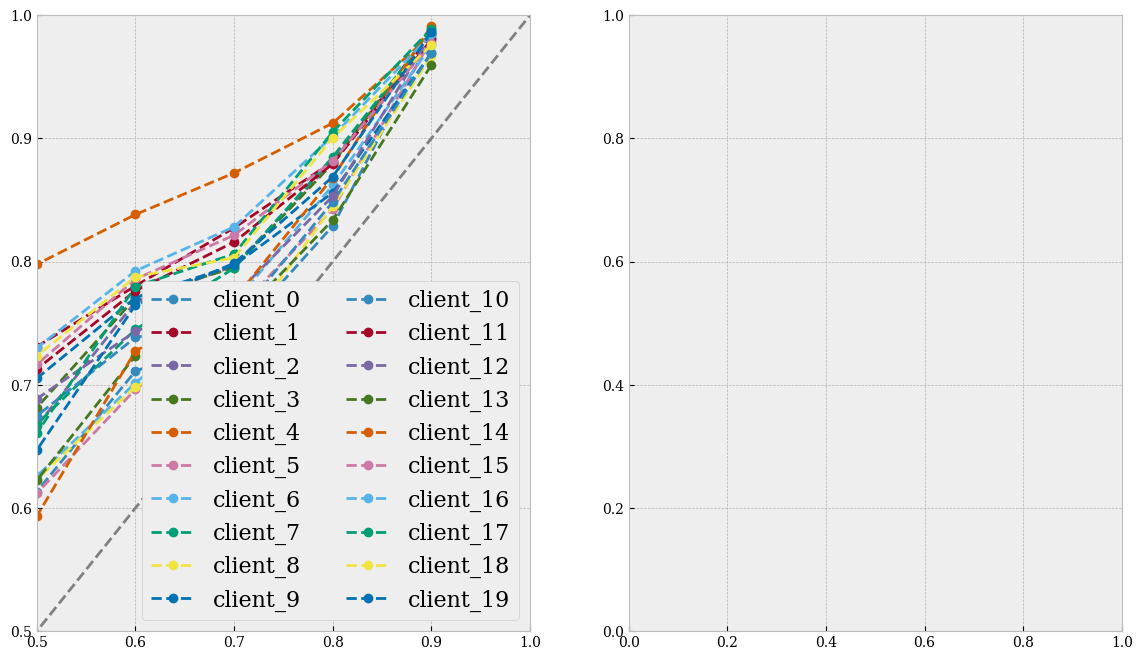

In [16]:
fedavg_val_scores = experiments['fedavg']['temp_val_scores']
fedavg_test_scores = experiments['fedavg']['temp_test_scores']
fedavg_val_targets = experiments['fedavg']['val_targets']
fedavg_test_targets = experiments['fedavg']['test_targets']

client_coverage = defaultdict(list)
client_size = defaultdict(list)
alphas = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
for alpha in alphas:
    index = get_index(fedavg_val_targets, clients_class_map['client_6'])
    q = cp.calibrate_lac(fedavg_val_scores[index], fedavg_val_targets[index], alpha=alpha)
    psets = cp.inference_lac(fedavg_test_scores, q)
    for client, index in clients_class_map.items():
        index = get_index(fedavg_test_targets, clients_class_map[client])
        client_psets = psets[index]
        client_targets = fedavg_test_targets[index]
        client_coverage[client].append(cp.get_coverage(client_psets, client_targets))
        client_size[client].append(cp.get_size(client_psets))


fontsize=16

fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
ax[0].plot([0, 1], [0, 1], '--', color='gray')
for client, coverage in client_coverage.items():
    ax[0].plot(1-alphas, coverage, 'o--', label=client)
    # ax[0].plot(*zip(*exp_1['coverage'].items()), style, marker='*', label=exp_1_label, markersize=markersize+4, c='C3')
    # ax[1].plot(*zip(*exp_1['size'].items()), style, marker='*', label=exp_1_label, markersize=markersize+4, c='C3')

ax[0].set_xlim(0.5, 1)
ax[0].set_ylim(0.5, 1)
ax[0].legend(fancybox=True, fontsize=fontsize, loc='best', ncol=2, framealpha=1.0)
# ax[1].set_ylim(0, num_classes)
# ax[0].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
# ax[1].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
# ax[0].set_ylabel('Coverage', fontsize=fontsize)
# ax[1].set_ylabel('Set size', fontsize=fontsize)
# ax[0].set_xticks([0.4, 0.6, 0.7, 0.8, 0.9])
# ax[0].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
# ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax[0].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# ax[0].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# ax[1].set_yticks([1, 2, 3, 4, 5, 6])
# ax[1].set_yticks([1, 5, 10, 15])
# ax[1].set_yticks([1, 2, 3, 4, 5])
# ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[0].legend(fancybox=False, fontsize=fontsize-8, loc='lower center', framealpha=1.0)
# ax[1].legend(fancybox=False, fontsize=fontsize-8, loc='upper center', framealpha=1.0)

# plt.tight_layout()
# plt.savefig(fig_dir / f'experiment-1-{dataset}-{method}.eps', bbox_inches='tight')
# plt.savefig(fig_dir / f'naive-{dataset}.eps', bbox_inches='tight')
# plt.show()


In [17]:
client_q = cp.calibrate_lac(val_scores, val_targets, alpha=0.1)
psets = cp.inference_lac(test_scores, client_q)
for i, exp in enumerate(experiments.keys()):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=0.1)
    psets = cp.inference_lac(test_scores, q)

    ax[0, i].set_title(exp)
    ax[0, i].bar(range(num_classes), cp.get_efficiency_by_class(psets, test_targets, num_classes=num_classes).values())
    ax[0, i].set_xlabel('class')
    ax[0, i].set_ylabel('set size')
    ax[0, i].set_ylim(0, num_classes)
    # ax[i].set_ylim(0, 20)
    # plt.bar(range(num_classes), test_scores.std(0))
    
    ax[1, i].set_title(exp)
    ax[1, i].bar(range(num_classes), cp.get_coverage_by_class(psets, test_targets, num_classes=num_classes).values())
    ax[1, i].set_xlabel('class')
    ax[1, i].set_ylabel('coverage')
    ax[1, i].set_ylim(0., 1)
plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [75]:
exp = 'tct'
alpha = 0.05
k = 4
allow_empty_sets = True
cal_index = _val_df.aggregated_fitzpatrick_scale == k
test_index = _test_df.aggregated_fitzpatrick_scale == 6
val_scores = experiments[exp]['temp_val_scores']
test_scores = experiments[exp]['temp_test_scores']
val_targets = experiments[exp]['val_targets']
test_targets = experiments[exp]['test_targets']
q = cp.calibrate_lac(val_scores[cal_index], val_targets[cal_index], alpha=alpha, )
q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha, )
cal_psets = cp.inference_lac(test_scores[_test_df.aggregated_fitzpatrick_scale == k], q, allow_empty_sets=allow_empty_sets)
test_psets = cp.inference_lac(test_scores[test_index], q, allow_empty_sets=allow_empty_sets)

cal_coverage = cp.get_coverage(cal_psets, test_targets[_test_df.aggregated_fitzpatrick_scale == k])
cal_size = cp.get_size(cal_psets)
test_coverage = cp.get_coverage(test_psets, test_targets[test_index])
test_size = cp.get_size(test_psets)

print(f'skin type 3\t {cal_coverage:.2f}  |  {cal_size:.1f}')
print(f'skin type 6\t {test_coverage:.2f}  |  {test_size:.1f}')

NameError: name '_val_df' is not defined

KeyError: 'temp_val_scores'

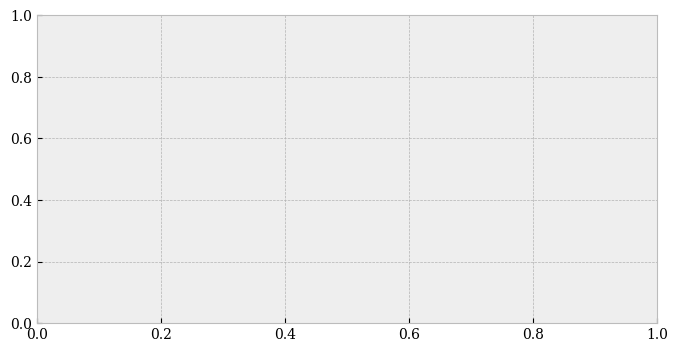

In [74]:
alpha = 0.05
alpha = 0.10
fontsize = 20
allow_empty_sets = False 

fig, ax = plt.subplots(ncols=1, figsize=(8, 4))
# fig.suptitle(exp + ' lac', fontsize=fontsize+4, y=1.10)

fedavg_val_scores = experiments['fedavg']['temp_val_scores']
fedavg_test_scores = experiments['fedavg']['temp_test_scores']
fedavg_val_targets = experiments['fedavg']['val_targets']
fedavg_test_targets = experiments['fedavg']['test_targets']


fedavg_iid_val_scores = experiments['fedavg_iid']['temp_val_scores']
fedavg_iid_test_scores = experiments['fedavg_iid']['temp_test_scores']
fedavg_iid_val_targets = experiments['fedavg_iid']['val_targets']
fedavg_iid_test_targets = experiments['fedavg_iid']['test_targets']

assert (fedavg_test_targets == fedavg_iid_test_targets).all()
fedavg_corr = fedavg_test_scores.argmax(1) == fedavg_test_targets
fedavg_iid_corr = fedavg_iid_test_scores.argmax(1) == fedavg_iid_test_targets
both = fedavg_corr == fedavg_iid_corr
# both = fedavg_test_scores.argmax(1) == fedavg_iid_test_scores.argmax(1)

fedavg_q = cp.calibrate_lac(fedavg_val_scores, fedavg_val_targets, alpha=alpha)
# fedavg_psets = cp.inference_lac(fedavg_test_scores, fedavg_q, allow_empty_sets=allow_empty_sets)
fedavg_psets = cp.inference_lac(fedavg_test_scores[both], fedavg_q, allow_empty_sets=allow_empty_sets)
fedavg_size_counts = fedavg_psets.sum(1).bincount().tolist()
fedavg_iid_q = cp.calibrate_lac(fedavg_iid_val_scores, fedavg_iid_val_targets, alpha=alpha)
# fedavg_iid_psets = cp.inference_lac(fedavg_iid_test_scores, fedavg_iid_q, allow_empty_sets=allow_empty_sets)
fedavg_iid_psets = cp.inference_lac(fedavg_iid_test_scores[both], fedavg_iid_q, allow_empty_sets=allow_empty_sets)
fedavg_iid_size_counts = fedavg_iid_psets.sum(1).bincount().tolist()
# print(exp, cp.get_coverage(psets, test_targets))
# print(exp, cp.get_size(psets))
fedavg_iid_label = 'Homogeneous (IID)'
fedavg_label = 'Heterogeneous (non-IID)'
offset = 0.5
width = 0.5
ax.bar(np.arange(len(fedavg_iid_size_counts)) + offset, fedavg_iid_size_counts, width=-width, label=fedavg_iid_label, align='edge')
ax.bar(np.arange(len(fedavg_size_counts)) , fedavg_size_counts, width=-width, label=fedavg_label, hatch='-', align='edge')
# ax.hist(psets.sum(1), histtype='step', lw=5, bins=20, label=label, alpha=0.5)
# ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
ax.set_xlabel('Prediction set size', fontsize=fontsize, labelpad=8)
ax.set_ylabel('Count', fontsize=fontsize, labelpad=4)
ax.xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax.yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax.set_xticks([1, 10, 20, 30, 40])
ax.set_yticks([0, 250, 500, 750, 1000])
ax.set_xlim(0, 40)

# fig.tight_layout()
plt.legend(fontsize=fontsize, fancybox=True)
plt.subplots_adjust(bottom=0.15)
plt.savefig(fig_dir / f'{dataset}-heterogeneous-set-sizes.eps')
plt.show()


correct fedavg_iid 1.0
correct fedavg_iid 4.0
incorrect fedavg_iid 0.7770735621452332
incorrect fedavg_iid 7.6
correct fedavg 1.0
correct fedavg 14.7
incorrect fedavg 0.8621426224708557
incorrect fedavg 19.8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


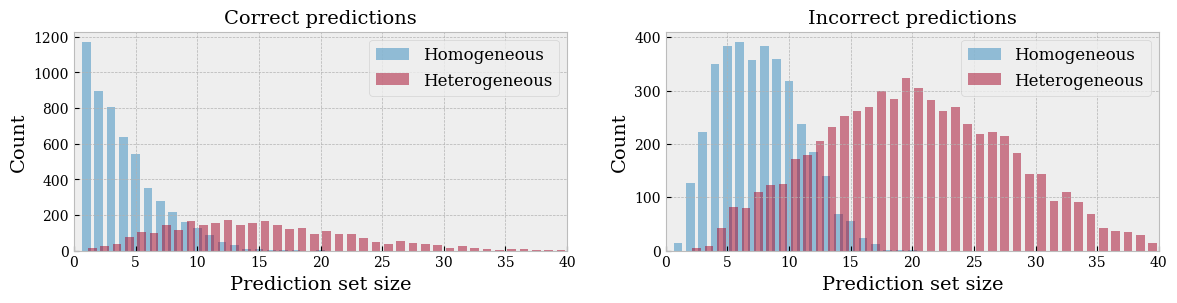

In [18]:
# alpha = 0.05
alpha = 0.10
y = 1
# alpha = 0.1
fontsize = 14
allow_empty_sets = False 

fig, ax = plt.subplots(ncols=2, figsize=(14, 3))
# fig.suptitle(exp + ' lac', fontsize=fontsize+4, y=1.10)

for i, exp in enumerate(('fedavg_iid', 'fedavg')):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
    psets = cp.inference_lac(test_scores, q, allow_empty_sets=allow_empty_sets)
    
    correct_index = test_scores.argmax(1) == test_targets
    correct_psets = psets[correct_index]
    correct_test_targets = test_targets[correct_index]
    
    correct_size_counts = correct_psets.sum(1).bincount().tolist()
    print('correct', exp, cp.get_coverage(correct_psets, correct_test_targets))
    print('correct', exp, cp.get_size(correct_psets))
    
    incorrect_index = test_scores.argmax(1) != test_targets
    incorrect_psets = psets[incorrect_index]
    incorrect_test_targets = test_targets[incorrect_index]
    
    incorrect_size_counts = incorrect_psets.sum(1).bincount().tolist()
    print('incorrect', exp, cp.get_coverage(incorrect_psets, incorrect_test_targets))
    print('incorrect', exp, cp.get_size(incorrect_psets))
    
    
    if exp == 'fedavg_iid':
        label = 'Homogeneous'
        offset = 0
    elif exp == 'fedavg':
        label = 'Heterogeneous'
        offset = 0.5
    
    ax[0].bar(np.arange(len(correct_size_counts)) + offset, correct_size_counts, width=0.7, label=label, alpha=0.5)
    # ax[0].step(np.arange(len(correct_size_counts)) + offset, correct_size_counts, label=label, alpha=1)
    ax[0].set_title(fr'Correct predictions', fontsize=fontsize, y=y)
    ax[0].set_xlabel('Prediction set size', fontsize=fontsize)
    ax[0].set_ylabel('Count', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize-2, fancybox=True)
    ax[0].xaxis.set_tick_params(labelsize=fontsize-4)
    ax[0].yaxis.set_tick_params(labelsize=fontsize-4)
    # ax[0].axvline(correct_psets.sum(1).median(), color=f'C{i}')

    ax[0].set_xlim(0, 40)
    
    ax[1].bar(np.arange(len(incorrect_size_counts)) + offset, incorrect_size_counts, width=0.7, label=label, alpha=0.5)
    # ax[1].step(np.arange(len(incorrect_size_counts)) + offset, incorrect_size_counts, label=label, alpha=1)
    ax[1].set_title(fr'Incorrect predictions', fontsize=fontsize, y=y)
    ax[1].set_xlabel('Prediction set size', fontsize=fontsize)
    ax[1].set_ylabel('Count', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize-2, fancybox=True)
    ax[1].xaxis.set_tick_params(labelsize=fontsize-4)
    ax[1].yaxis.set_tick_params(labelsize=fontsize-4)
    ax[1].set_xlim(0, 40)
    # ax[1].axvline(incorrect_psets.sum(1).median(), color=f'C{i}')
        
    # fig.tight_layout()
    
plt.subplots_adjust(bottom=0.15)
plt.savefig(fig_dir / 'heterogeneous-set-sizes.eps', bbox_inches='tight',)
plt.show()

correct fedavg_iid 1.0
correct fedavg_iid 4.0
incorrect fedavg_iid 0.7770735621452332
incorrect fedavg_iid 7.6
correct fedavg 1.0
correct fedavg 14.7
incorrect fedavg 0.8621426224708557
incorrect fedavg 19.8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


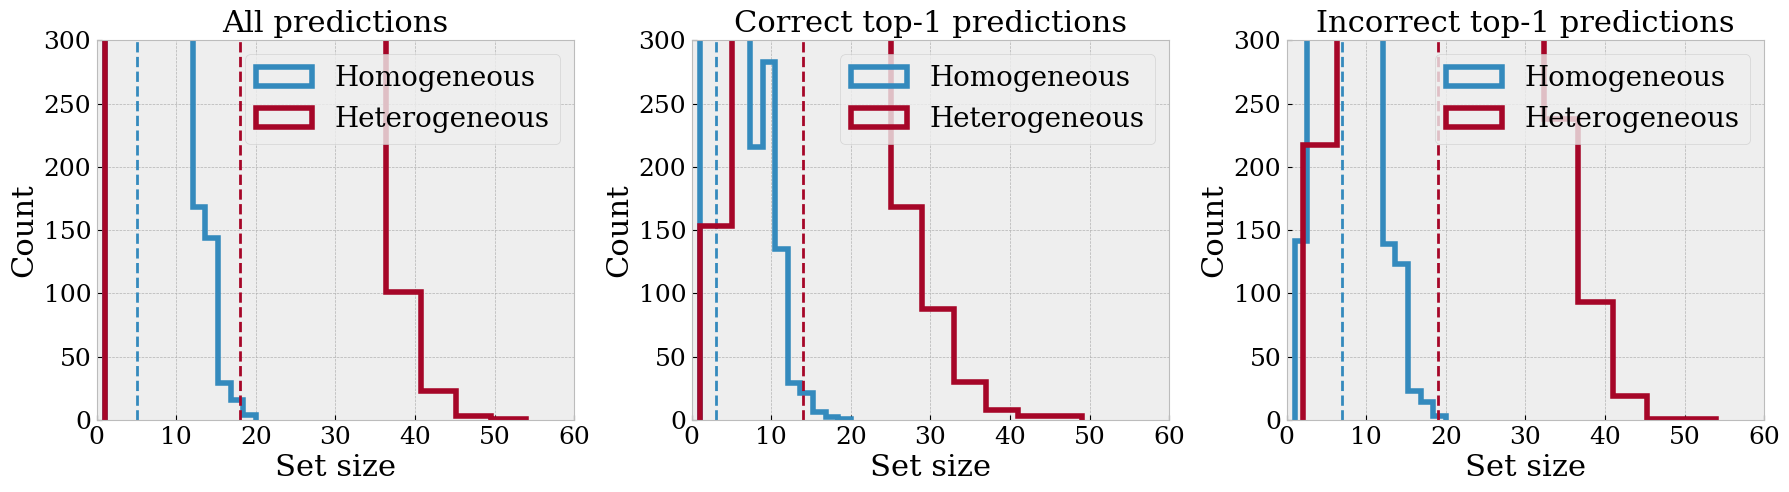

In [19]:
# alpha = 0.05
alpha = 0.10
y = 1
# alpha = 0.1
fontsize = 22
allow_empty_sets = False 
bins = 12
lw = 4

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
# fig.suptitle(exp + ' lac', fontsize=fontsize+4, y=1.10)

for i, exp in enumerate(('fedavg_iid', 'fedavg')):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
    psets = cp.inference_lac(test_scores, q, allow_empty_sets=allow_empty_sets)
    
    correct_index = test_scores.argmax(1) == test_targets
    correct_psets = psets[correct_index]
    correct_test_targets = test_targets[correct_index]
    
    correct_size_counts = correct_psets.sum(1).bincount().tolist()
    print('correct', exp, cp.get_coverage(correct_psets, correct_test_targets))
    print('correct', exp, cp.get_size(correct_psets))
    
    incorrect_index = test_scores.argmax(1) != test_targets
    incorrect_psets = psets[incorrect_index]
    incorrect_test_targets = test_targets[incorrect_index]
    
    incorrect_size_counts = incorrect_psets.sum(1).bincount().tolist()
    print('incorrect', exp, cp.get_coverage(incorrect_psets, incorrect_test_targets))
    print('incorrect', exp, cp.get_size(incorrect_psets))
    
    
    if exp == 'fedavg_iid':
        label = 'Homogeneous'
        offset = 0
    elif exp == 'fedavg':
        label = 'Heterogeneous'
        offset = 0.5
        
    ax[0].hist(psets.sum(1), label=label, alpha=1, histtype='step', bins=bins, lw=lw)
    ax[0].set_title(fr'All predictions', fontsize=fontsize, y=y)
    ax[0].set_xlabel('Set size', fontsize=fontsize)
    ax[0].set_ylabel('Count', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize-2, fancybox=True)
    ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=4)
    ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=4)
    ax[0].axvline(psets.sum(1).median(), ls='--', color=f'C{i}')
    ax[0].set_xlim(0, 60)
    ax[0].set_ylim(0, 300)
    
    ax[1].hist(correct_psets.sum(1), label=label, alpha=1, histtype='step', bins=bins, lw=lw)
    ax[1].set_title(fr'Correct top-1 predictions', fontsize=fontsize, y=y)
    ax[1].set_xlabel('Set size', fontsize=fontsize)
    ax[1].set_ylabel('Count', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize-2, fancybox=True)
    ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=4)
    ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=4)
    ax[1].axvline(correct_psets.sum(1).median(), ls='--', color=f'C{i}')
    ax[1].set_xlim(0, 60)
    ax[1].set_ylim(0, 300)
        
    ax[2].hist(incorrect_psets.sum(1), label=label, alpha=1, histtype='step', bins=bins, lw=lw)
    ax[2].set_title(fr'Incorrect top-1 predictions', fontsize=fontsize, y=y)
    ax[2].set_xlabel('Set size', fontsize=fontsize)
    ax[2].set_ylabel('Count', fontsize=fontsize)
    ax[2].legend(fontsize=fontsize-2, fancybox=True)
    ax[2].xaxis.set_tick_params(labelsize=fontsize-4, pad=4)
    ax[2].yaxis.set_tick_params(labelsize=fontsize-4, pad=4)
    ax[2].axvline(incorrect_psets.sum(1).median(), ls='--', color=f'C{i}')
    ax[2].set_xlim(0, 60)
    ax[2].set_ylim(0, 300)
    
    fig.tight_layout()
    
plt.subplots_adjust(bottom=0.15)
plt.savefig(fig_dir / f'{dataset}-set-sizes.eps', bbox_inches='tight',)
plt.show()

In [98]:
def get_client_accuracy(experiment, clients_class_map):
    test_scores = experiment['test_scores']
    test_targets = experiment['test_targets']

    clients_test_index = {
        client: torch.any(torch.stack([test_targets == label for label in labels]), 0)
        for client, labels in clients_class_map.items()
    }
    def accuracy(scores, targets):
        n = targets.size(0)
        correct = scores.argmax(1) == targets
        return correct.sum() / n
        
    return {client: accuracy(test_scores[index], test_targets[index]).item() 
            for client, index in clients_test_index.items()}

In [99]:
def get_skin_type_accuracy(experiment, test_df):
    results = {}
    skin_types = sorted(test_df.aggregated_fitzpatrick_scale.unique())
    for st in skin_types:
        index = test_df.aggregated_fitzpatrick_scale == st
        scores = experiment['test_scores'][index]
        targets = experiment['test_targets'][index]
        results[st] = accuracy(scores, targets)
    return results
   

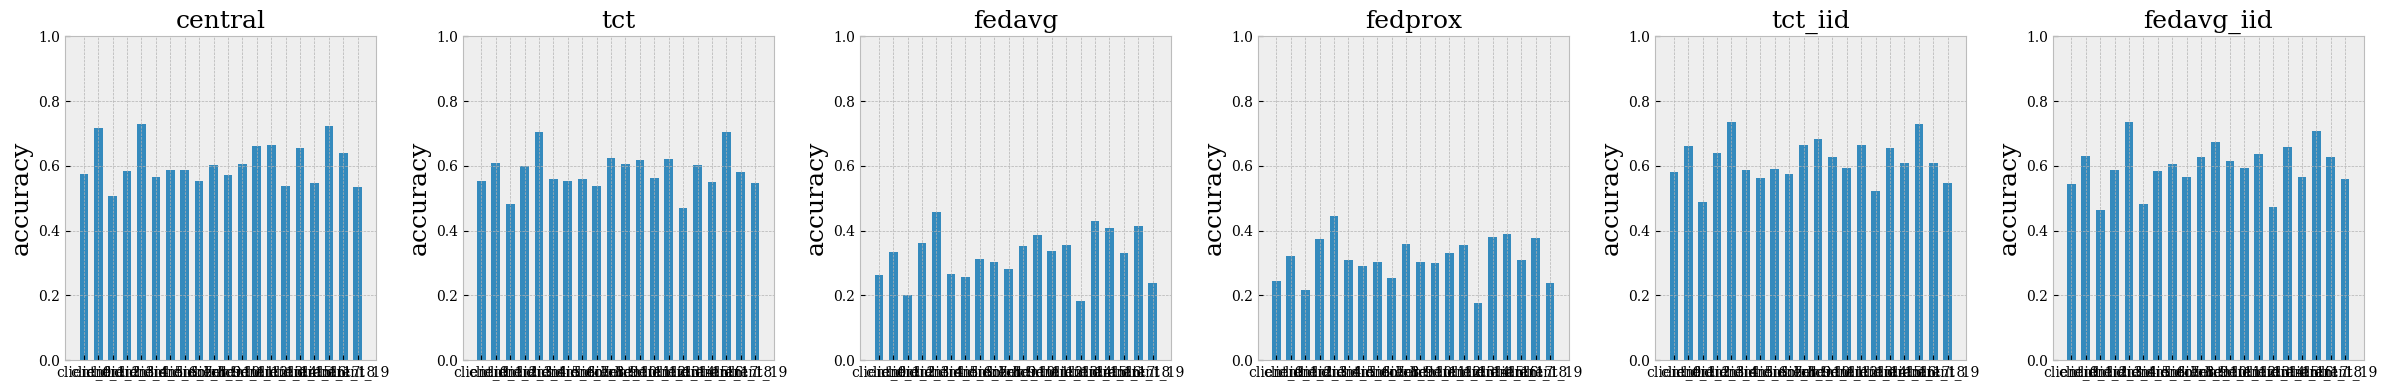

In [161]:
def plot_client_accuracy(experiments, height=4, width=4, fontsize=18, dataset=dataset):
    fig, ax = plt.subplots(ncols=len(experiments), figsize=(width*len(experiments), height))
    for i, (k, v) in enumerate(experiments.items()):
        ax[i].set_title(k, fontsize=fontsize)
        if dataset == 'fitzpatrick':
            ax[i].bar(*zip(*get_skin_type_accuracy(v, test_df).items()), width=0.3)
            ax[i].set_xlabel('skin type', fontsize=fontsize)
        else:
            ax[i].bar(*zip(*get_client_accuracy(v, clients_class_map).items()), width=0.6)
        ax[i].set_ylim(0, 1)
        ax[i].set_ylabel('accuracy', fontsize=fontsize)
    fig.tight_layout()
    plt.show()
    
plot_client_accuracy(experiments, dataset=dataset)